In [2]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.models import mobilenet_v3_large

In [3]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [4]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 750
_C.IMAGE_H = 750
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [5]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [6]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [7]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [8]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [9]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [10]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor()])

In [11]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

30213
7629


Label: clear
mask: blur

tensor([0., 0., 0., 0.])
../data/train/blur/clear_gt/real_blur/gt_197.png


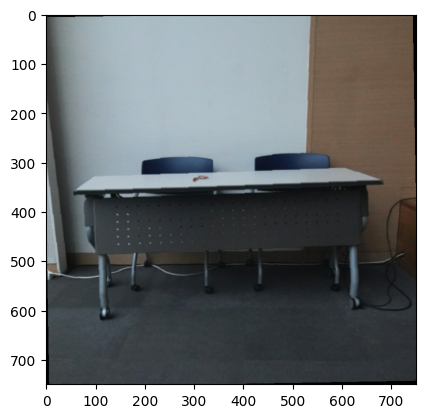

In [12]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[5000])
print(train_dataset.im_path(5000))

Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

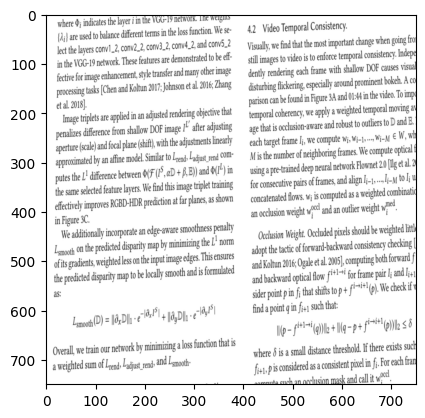

In [13]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [14]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [15]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [16]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [17]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

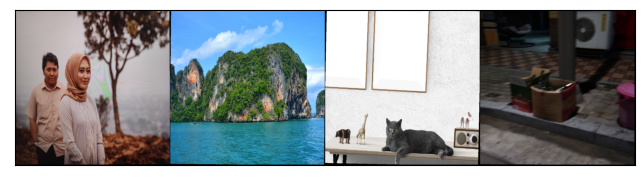

In [18]:
def show_batch(dl, nmax=16):
    for images, labels, masks in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [19]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [20]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [21]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [22]:
images, targets, masks = next(iter(val_loader))
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(1.), tensor(0.7500), tensor(0.8571))


In [23]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [24]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets, masks = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets, masks = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [26]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [27]:
# checking up the shapes of the datas
for xb, yb, masks in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 750, 750])
torch.Size([4, 4])
torch.Size([4, 4])


In [28]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model number 2: shufflenet from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)

In [29]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
        self.model.fc = nn.Sequential(
          nn.Linear(1024, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.fc.parameters():
            param.requires_grad = True
    def unfreeze_total(self):
        for param in self.model.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [30]:
model = CustomModel().to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0
/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


672836

In [31]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 750, 750])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.4964, 0.4852, 0.4930, 0.4758],
        [0.4920, 0.4887, 0.5005, 0.4749]], device='cuda:0')


In [32]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(163577856, 7849984)

In [33]:
epochs = 10
max_lr = 0.001
grad_clip = 0.8
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.0, rec 0.0, f2 0.0
demoir
prec 0.0, rec 0.0, f2 0.0
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.0, rec 0.0, f2 0.0


[{'val_loss': 0.6759080290794373,
  'val_score': 0.0,
  'val_score_blur': 0.0,
  'val_score_haze': 0.0,
  'val_score_rain': 0.0,
  'val_score_demoir': 0.0}]

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9999999999999984, rec 0.6646464646464639, f2 0.7985436893199076
demoir
prec 0.8688524590163887, rec 0.15899999999999984, f2 0.26880811496169904
haze
prec 0.999153976311336, rec 0.984166666666666, f2 0.9916036943739744
rain
prec 0.9795673076923065, rec 0.7966764418377313, f2 0.8787061994604207
Epoch [0], last_lr: 0.0003, train_loss: 0.3278, val_loss: 0.1009, val_score: 0.7960, val_score_blur: 0.7985, val_score_demoir: 0.2688, val_score_haze: 0.9916, val_score_rain: 0.8787


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8976958525345614, rec 0.9838383838383828, f2 0.9387951807223918
demoir
prec 0.8099630996309957, rec 0.8779999999999991, f2 0.8426103646828014
haze
prec 0.9966638865721427, rec 0.9958333333333326, f2 0.9962484368481861
rain
prec 0.8869955156950665, rec 0.9667644183773206, f2 0.9251637043961324
Epoch [1], last_lr: 0.0008, train_loss: 0.1539, val_loss: 0.0541, val_score: 0.9282, val_score_blur: 0.9388, val_score_demoir: 0.8426, val_score_haze: 0.9962, val_score_rain: 0.9252


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9302325581395341, rec 0.9696969696969687, f2 0.9495548961419327
demoir
prec 0.7921862011637567, rec 0.9529999999999991, f2 0.8651838402173881
haze
prec 0.9908789386401319, rec 0.9958333333333326, f2 0.9933499584367395
rain
prec 0.938154138915318, rec 0.9638318670576725, f2 0.9508196721306467
Epoch [2], last_lr: 0.0010, train_loss: 0.1432, val_loss: 0.0500, val_score: 0.9406, val_score_blur: 0.9496, val_score_demoir: 0.8652, val_score_haze: 0.9933, val_score_rain: 0.9508


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8532513181019326, rec 0.9808080808080798, f2 0.9125939849619076
demoir
prec 0.8655804480651722, rec 0.8499999999999991, f2 0.8577194752769965
haze
prec 0.974796747967479, rec 0.9991666666666659, f2 0.986831275719664
rain
prec 0.8390325271059209, rec 0.9833822091886598, f2 0.9054905490544078
Epoch [3], last_lr: 0.0010, train_loss: 0.1284, val_loss: 0.0596, val_score: 0.9190, val_score_blur: 0.9126, val_score_demoir: 0.8577, val_score_haze: 0.9868, val_score_rain: 0.9055


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9968186638388112, rec 0.9494949494949485, f2 0.9725814795649416
demoir
prec 0.8395176252319102, rec 0.904999999999999, f2 0.8710298363806356
haze
prec 0.9933719966859976, rec 0.9991666666666659, f2 0.9962609056912316
rain
prec 0.903985507246376, rec 0.9755620723362649, f2 0.9384109073807879
Epoch [4], last_lr: 0.0008, train_loss: 0.1169, val_loss: 0.0415, val_score: 0.9461, val_score_blur: 0.9726, val_score_demoir: 0.8710, val_score_haze: 0.9963, val_score_rain: 0.9384


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9367088607594929, rec 0.9717171717171708, f2 0.9538919186906247
demoir
prec 0.8731117824773404, rec 0.8669999999999991, f2 0.8700451580526852
haze
prec 0.9933222036727872, rec 0.9916666666666659, f2 0.992493744786822
rain
prec 0.9705593719332669, rec 0.9667644183773206, f2 0.9686581782561102
Epoch [5], last_lr: 0.0006, train_loss: 0.1063, val_loss: 0.0404, val_score: 0.9486, val_score_blur: 0.9539, val_score_demoir: 0.8700, val_score_haze: 0.9925, val_score_rain: 0.9687


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9564356435643555, rec 0.9757575757575747, f2 0.965999999999499
demoir
prec 0.8795180722891557, rec 0.8759999999999991, f2 0.877755511021543
haze
prec 0.9991638795986615, rec 0.9958333333333326, f2 0.9974958263767948
rain
prec 0.9599609374999991, rec 0.9608993157380245, f2 0.960429897410344
Epoch [6], last_lr: 0.0004, train_loss: 0.0997, val_loss: 0.0349, val_score: 0.9527, val_score_blur: 0.9660, val_score_demoir: 0.8778, val_score_haze: 0.9975, val_score_rain: 0.9604


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9786368260427253, rec 0.9717171717171708, f2 0.9751647237704062
demoir
prec 0.9017580144777654, rec 0.8719999999999991, f2 0.8866293848495247
haze
prec 0.9999999999999992, rec 0.989166666666666, f2 0.99455383326301
rain
prec 0.9218749999999992, rec 0.9804496578690117, f2 0.950260540027922
Epoch [7], last_lr: 0.0002, train_loss: 0.0864, val_loss: 0.0337, val_score: 0.9538, val_score_blur: 0.9752, val_score_demoir: 0.8866, val_score_haze: 0.9946, val_score_rain: 0.9503


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9883597883597873, rec 0.9434343434343424, f2 0.9653746770020831
demoir
prec 0.9068577277379725, rec 0.8859999999999991, f2 0.8963075366712239
haze
prec 0.9966499162479054, rec 0.9916666666666659, f2 0.994152046783125
rain
prec 0.9086799276672687, rec 0.9824046920821105, f2 0.9441052137148591
Epoch [8], last_lr: 0.0000, train_loss: 0.0775, val_loss: 0.0364, val_score: 0.9520, val_score_blur: 0.9654, val_score_demoir: 0.8963, val_score_haze: 0.9942, val_score_rain: 0.9441


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9721362229102157, rec 0.9515151515151505, f2 0.9617151607958236
demoir
prec 0.8530499075785575, rec 0.922999999999999, f2 0.8866474543702972
haze
prec 0.9966611018363932, rec 0.9949999999999992, f2 0.9958298582146785
rain
prec 0.9523809523809516, rec 0.9775171065493636, f2 0.9647853352624032
Epoch [9], last_lr: 0.0000, train_loss: 0.0728, val_loss: 0.0363, val_score: 0.9537, val_score_blur: 0.9617, val_score_demoir: 0.8866, val_score_haze: 0.9958, val_score_rain: 0.9648
CPU times: user 50min 9s, sys: 12min 17s, total: 1h 2min 27s
Wall time: 1h 15min 59s


In [36]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9719334719334709, rec 0.9444444444444434, f2 0.9579918032781876
demoir
prec 0.9027196652719656, rec 0.8629999999999991, f2 0.8824130879340596
haze
prec 0.9811165845648597, rec 0.9958333333333326, f2 0.9884201819680682
rain
prec 0.9598086124401906, rec 0.9804496578690117, f2 0.9700193423592671
Epoch [0], last_lr: 0.0003, train_loss: 0.0757, val_loss: 0.0348, val_score: 0.9521, val_score_blur: 0.9580, val_score_demoir: 0.8824, val_score_haze: 0.9884, val_score_rain: 0.9700


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.945382323733862, rec 0.9616161616161606, f2 0.9534301452173258
demoir
prec 0.9404255319148922, rec 0.6629999999999994, f2 0.7777126099701884
haze
prec 0.9653505237711516, rec 0.9983333333333326, f2 0.9815649324042516
rain
prec 0.9757575757575747, rec 0.9442815249266853, f2 0.9597615499249834
Epoch [1], last_lr: 0.0008, train_loss: 0.0920, val_loss: 0.0491, val_score: 0.9267, val_score_blur: 0.9534, val_score_demoir: 0.7777, val_score_haze: 0.9816, val_score_rain: 0.9598


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9906735751295326, rec 0.9656565656565647, f2 0.978005115089013
demoir
prec 0.8640226628895177, rec 0.914999999999999, f2 0.8887809616313597
haze
prec 0.9740048740861081, rec 0.9991666666666659, f2 0.9864253393660152
rain
prec 0.9283054003724387, rec 0.9745845552297155, f2 0.9508822126842871
Epoch [2], last_lr: 0.0010, train_loss: 0.1074, val_loss: 0.0378, val_score: 0.9522, val_score_blur: 0.9780, val_score_demoir: 0.8888, val_score_haze: 0.9864, val_score_rain: 0.9509


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9538310412573664, rec 0.9808080808080798, f2 0.9671314741030848
demoir
prec 0.9304347826086945, rec 0.7489999999999992, f2 0.82991689750643
haze
prec 0.9991582491582484, rec 0.989166666666666, f2 0.994137353433335
rain
prec 0.9819095477386924, rec 0.9550342130987283, f2 0.9682854311194198
Epoch [3], last_lr: 0.0010, train_loss: 0.1077, val_loss: 0.0418, val_score: 0.9451, val_score_blur: 0.9671, val_score_demoir: 0.8299, val_score_haze: 0.9941, val_score_rain: 0.9683


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9770354906054269, rec 0.9454545454545444, f2 0.9609856262828667
demoir
prec 0.9698113207547151, rec 0.5139999999999995, f2 0.6718954248361475
haze
prec 0.9991482112436109, rec 0.9774999999999993, f2 0.9882055602353881
rain
prec 0.9640427599611264, rec 0.9696969696969687, f2 0.9668615984400449
Epoch [4], last_lr: 0.0008, train_loss: 0.1059, val_loss: 0.0521, val_score: 0.9147, val_score_blur: 0.9610, val_score_demoir: 0.6719, val_score_haze: 0.9882, val_score_rain: 0.9669


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9722222222222212, rec 0.9191919191919182, f2 0.9449636552435284
demoir
prec 0.8582302568981914, rec 0.901999999999999, f2 0.8795709410038876
haze
prec 0.9707554833468718, rec 0.9958333333333326, f2 0.9831345125457766
rain
prec 0.9936775553213899, rec 0.9217986314760499, f2 0.956389452332157
Epoch [5], last_lr: 0.0006, train_loss: 0.0966, val_loss: 0.0446, val_score: 0.9427, val_score_blur: 0.9450, val_score_demoir: 0.8796, val_score_haze: 0.9831, val_score_rain: 0.9564


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9830890642615546, rec 0.8808080808080799, f2 0.929142248268014
demoir
prec 0.9326424870466309, rec 0.7199999999999993, f2 0.8126410835209519
haze
prec 0.9793899422918377, rec 0.9899999999999992, f2 0.9846663903849114
rain
prec 0.9866803278688514, rec 0.9413489736070372, f2 0.9634817408699343
Epoch [6], last_lr: 0.0004, train_loss: 0.0912, val_loss: 0.0478, val_score: 0.9287, val_score_blur: 0.9291, val_score_demoir: 0.8126, val_score_haze: 0.9847, val_score_rain: 0.9635


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9977272727272716, rec 0.8868686868686859, f2 0.9390374331545809
demoir
prec 0.9180522565320653, rec 0.7729999999999992, f2 0.8393051031482541
haze
prec 0.997502081598667, rec 0.9983333333333326, f2 0.9979175343601823
rain
prec 0.9477186311787064, rec 0.9745845552297155, f2 0.9609638554211859
Epoch [7], last_lr: 0.0002, train_loss: 0.0832, val_loss: 0.0393, val_score: 0.9394, val_score_blur: 0.9390, val_score_demoir: 0.8393, val_score_haze: 0.9979, val_score_rain: 0.9610


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9935691318327964, rec 0.9363636363636354, f2 0.9641185647420891
demoir
prec 0.9068255687973987, rec 0.8369999999999992, f2 0.8705148205923235
haze
prec 0.9991624790619758, rec 0.9941666666666659, f2 0.9966583124472853
rain
prec 0.9521531100478461, rec 0.9726295210166168, f2 0.9622823984521104
Epoch [8], last_lr: 0.0000, train_loss: 0.0754, val_loss: 0.0362, val_score: 0.9514, val_score_blur: 0.9641, val_score_demoir: 0.8705, val_score_haze: 0.9967, val_score_rain: 0.9623


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9914712153518113, rec 0.9393939393939384, f2 0.9647302904559307
demoir
prec 0.8508604206500948, rec 0.8899999999999991, f2 0.8699902248284339
haze
prec 0.9999999999999992, rec 0.9908333333333326, f2 0.9953955629965691
rain
prec 0.9407337723424263, rec 0.9775171065493636, f2 0.9587727708528069
Epoch [9], last_lr: 0.0000, train_loss: 0.0716, val_loss: 0.0392, val_score: 0.9490, val_score_blur: 0.9647, val_score_demoir: 0.8700, val_score_haze: 0.9954, val_score_rain: 0.9588


In [37]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.967032967032966, rec 0.9777777777777767, f2 0.9723756906072338
demoir
prec 0.9178571428571417, rec 0.7709999999999992, f2 0.8380434782603724
haze
prec 0.9991659716430351, rec 0.9983333333333326, f2 0.9987494789490616
rain
prec 0.9721669980119274, rec 0.9560117302052776, f2 0.9640216855588878
Epoch [0], last_lr: 0.0003, train_loss: 0.0730, val_loss: 0.0365, val_score: 0.9481, val_score_blur: 0.9724, val_score_demoir: 0.8380, val_score_haze: 0.9987, val_score_rain: 0.9640


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9923995656894669, rec 0.9232323232323223, f2 0.9565672422810275
demoir
prec 0.872983870967741, rec 0.8659999999999991, f2 0.8694779116460853
haze
prec 0.9999999999999992, rec 0.9941666666666659, f2 0.9970748015038869
rain
prec 0.8331963845521768, rec 0.9912023460410547, f2 0.9053571428566457
Epoch [1], last_lr: 0.0008, train_loss: 0.0891, val_loss: 0.0480, val_score: 0.9342, val_score_blur: 0.9566, val_score_demoir: 0.8695, val_score_haze: 0.9971, val_score_rain: 0.9054


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9690831556503188, rec 0.9181818181818172, f2 0.9429460580907857
demoir
prec 0.8279192273924488, rec 0.9429999999999991, f2 0.8817204301070282
haze
prec 0.9851851851851845, rec 0.9974999999999993, f2 0.9913043478255863
rain
prec 0.9728915662650592, rec 0.9472140762463334, f2 0.9598811292714159
Epoch [2], last_lr: 0.0010, train_loss: 0.1039, val_loss: 0.0461, val_score: 0.9453, val_score_blur: 0.9429, val_score_demoir: 0.8817, val_score_haze: 0.9913, val_score_rain: 0.9599


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.972809667673715, rec 0.9757575757575747, f2 0.9742813918300588
demoir
prec 0.9487179487179475, rec 0.7029999999999993, f2 0.8075818495112849
haze
prec 0.9941812136325845, rec 0.9966666666666659, f2 0.9954223886803149
rain
prec 0.8867256637168135, rec 0.9794721407624624, f2 0.9307942405940197
Epoch [3], last_lr: 0.0010, train_loss: 0.1071, val_loss: 0.0437, val_score: 0.9341, val_score_blur: 0.9743, val_score_demoir: 0.8076, val_score_haze: 0.9954, val_score_rain: 0.9308


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9483430799220265, rec 0.9828282828282818, f2 0.965277777777277
demoir
prec 0.8599439775910357, rec 0.920999999999999, f2 0.8894253983577807
haze
prec 0.9637681159420283, rec 0.9974999999999993, f2 0.9803439803434797
rain
prec 0.9681908548707744, rec 0.9521016617790802, f2 0.9600788565790949
Epoch [4], last_lr: 0.0008, train_loss: 0.1007, val_loss: 0.0399, val_score: 0.9500, val_score_blur: 0.9653, val_score_demoir: 0.8894, val_score_haze: 0.9803, val_score_rain: 0.9601


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9967426710097709, rec 0.9272727272727264, f2 0.9607535321816032
demoir
prec 0.915040183696899, rec 0.7969999999999992, f2 0.8519508284334939
haze
prec 0.9966358284272491, rec 0.9874999999999993, f2 0.9920468815398926
rain
prec 0.9416267942583724, rec 0.9618768328445738, f2 0.9516441005797699
Epoch [5], last_lr: 0.0006, train_loss: 0.0965, val_loss: 0.0396, val_score: 0.9428, val_score_blur: 0.9608, val_score_demoir: 0.8520, val_score_haze: 0.9920, val_score_rain: 0.9516


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9615004935834146, rec 0.9838383838383828, f2 0.9725411882171725
demoir
prec 0.9123595505617967, rec 0.8119999999999992, f2 0.85925925925876
haze
prec 0.9991518235793038, rec 0.9816666666666659, f2 0.9903320722987846
rain
prec 0.9700897308075763, rec 0.9511241446725308, f2 0.9605133267517202
Epoch [6], last_lr: 0.0004, train_loss: 0.0912, val_loss: 0.0370, val_score: 0.9489, val_score_blur: 0.9725, val_score_demoir: 0.8593, val_score_haze: 0.9903, val_score_rain: 0.9605


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9717171717171708, rec 0.9717171717171708, f2 0.9717171717166707
demoir
prec 0.9065934065934056, rec 0.8249999999999992, f2 0.8638743455492384
haze
prec 0.9949874686716784, rec 0.9924999999999993, f2 0.9937421777216519
rain
prec 0.9634387351778646, rec 0.9530791788856295, f2 0.9582309582304573
Epoch [7], last_lr: 0.0002, train_loss: 0.0828, val_loss: 0.0362, val_score: 0.9500, val_score_blur: 0.9717, val_score_demoir: 0.8639, val_score_haze: 0.9937, val_score_rain: 0.9582


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9883351007423107, rec 0.9414141414141405, f2 0.9643041903771506
demoir
prec 0.8839835728952763, rec 0.8609999999999991, f2 0.8723404255314141
haze
prec 0.9966611018363932, rec 0.9949999999999992, f2 0.9958298582146785
rain
prec 0.9673590504451028, rec 0.9560117302052776, f2 0.9616519174036287
Epoch [8], last_lr: 0.0000, train_loss: 0.0757, val_loss: 0.0350, val_score: 0.9510, val_score_blur: 0.9643, val_score_demoir: 0.8723, val_score_haze: 0.9958, val_score_rain: 0.9617


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9978070175438585, rec 0.9191919191919182, f2 0.9568874868554409
demoir
prec 0.8947368421052622, rec 0.8499999999999991, f2 0.8717948717943712
haze
prec 0.9868095630667758, rec 0.9974999999999993, f2 0.9921259842514678
rain
prec 0.9732673267326722, rec 0.9608993157380245, f2 0.9670437776679692
Epoch [9], last_lr: 0.0000, train_loss: 0.0735, val_loss: 0.0374, val_score: 0.9496, val_score_blur: 0.9569, val_score_demoir: 0.8718, val_score_haze: 0.9921, val_score_rain: 0.9670


In [38]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9955604883462807, rec 0.9060606060606051, f2 0.9487043892115572
demoir
prec 0.8942917547568701, rec 0.8459999999999991, f2 0.8694758478926136
haze
prec 0.9941471571906347, rec 0.9908333333333326, f2 0.9924874791313856
rain
prec 0.9690927218344956, rec 0.9501466275659814, f2 0.9595261599205256
Epoch [0], last_lr: 0.0003, train_loss: 0.0752, val_loss: 0.0425, val_score: 0.9454, val_score_blur: 0.9487, val_score_demoir: 0.8695, val_score_haze: 0.9925, val_score_rain: 0.9595


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9807256235827653, rec 0.8737373737373728, f2 0.9241452991447998
demoir
prec 0.9158163265306111, rec 0.7179999999999993, f2 0.8049327354255152
haze
prec 0.997389033942558, rec 0.9549999999999993, f2 0.9757343550441993
rain
prec 0.951830443159922, rec 0.9657869012707713, f2 0.9587578845215757
Epoch [1], last_lr: 0.0008, train_loss: 0.0902, val_loss: 0.0528, val_score: 0.9216, val_score_blur: 0.9241, val_score_demoir: 0.8049, val_score_haze: 0.9757, val_score_rain: 0.9588


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9660842754367924, rec 0.9494949494949485, f2 0.957717778909331
demoir
prec 0.9037199124726467, rec 0.8259999999999992, f2 0.8631138975961562
haze
prec 0.9763843648208462, rec 0.9991666666666659, f2 0.9876441515645734
rain
prec 0.9750499001995998, rec 0.9550342130987283, f2 0.9649382716044373
Epoch [2], last_lr: 0.0010, train_loss: 0.1059, val_loss: 0.0410, val_score: 0.9465, val_score_blur: 0.9577, val_score_demoir: 0.8631, val_score_haze: 0.9876, val_score_rain: 0.9649


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.8021885521885516, rec 0.9626262626262616, f2 0.8751147842051966
demoir
prec 0.9112627986348112, rec 0.8009999999999992, f2 0.8525811601910923
haze
prec 0.9999999999999992, rec 0.9633333333333326, f2 0.9813242784375299
rain
prec 0.9903121636167912, rec 0.8993157380254145, f2 0.9426229508191722
Epoch [3], last_lr: 0.0010, train_loss: 0.1043, val_loss: 0.0597, val_score: 0.9157, val_score_blur: 0.8751, val_score_demoir: 0.8526, val_score_haze: 0.9813, val_score_rain: 0.9426


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9643211100099098, rec 0.9828282828282818, f2 0.9734867433711848
demoir
prec 0.8928188638799561, rec 0.8329999999999992, f2 0.8618727366782373
haze
prec 0.9991659716430351, rec 0.9983333333333326, f2 0.9987494789490616
rain
prec 0.9622266401590448, rec 0.946236559139784, f2 0.9541646131094054
Epoch [4], last_lr: 0.0008, train_loss: 0.1012, val_loss: 0.0385, val_score: 0.9502, val_score_blur: 0.9735, val_score_demoir: 0.8619, val_score_haze: 0.9987, val_score_rain: 0.9542


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.997856377277598, rec 0.9404040404040395, f2 0.9682787311487454
demoir
prec 0.8378378378378372, rec 0.8989999999999991, f2 0.8673420164008505
haze
prec 0.9999999999999992, rec 0.9916666666666659, f2 0.9958158995810892
rain
prec 0.9275092936802967, rec 0.9755620723362649, f2 0.9509290138156022
Epoch [5], last_lr: 0.0006, train_loss: 0.0964, val_loss: 0.0420, val_score: 0.9471, val_score_blur: 0.9683, val_score_demoir: 0.8673, val_score_haze: 0.9958, val_score_rain: 0.9509


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9989010989010978, rec 0.9181818181818172, f2 0.9568421052626577
demoir
prec 0.830341113105924, rec 0.924999999999999, f2 0.8751182592237202
haze
prec 0.9999999999999992, rec 0.9849999999999992, f2 0.9924433249365269
rain
prec 0.9539789069990404, rec 0.9726295210166168, f2 0.963213939980138
Epoch [6], last_lr: 0.0004, train_loss: 0.0899, val_loss: 0.0410, val_score: 0.9480, val_score_blur: 0.9568, val_score_demoir: 0.8751, val_score_haze: 0.9924, val_score_rain: 0.9632


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9810326659641717, rec 0.9404040404040395, f2 0.9602888086637591
demoir
prec 0.9091928251121065, rec 0.8109999999999992, f2 0.8572938689212765
haze
prec 0.9983164983164976, rec 0.9883333333333326, f2 0.9932998324953117
rain
prec 0.9692460317460307, rec 0.9550342130987283, f2 0.9620876415553827
Epoch [7], last_lr: 0.0002, train_loss: 0.0815, val_loss: 0.0374, val_score: 0.9467, val_score_blur: 0.9603, val_score_demoir: 0.8573, val_score_haze: 0.9933, val_score_rain: 0.9621


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9955555555555544, rec 0.9050505050505041, f2 0.9481481481476483
demoir
prec 0.9039351851851841, rec 0.7809999999999993, f2 0.8379828326175275
haze
prec 0.9974937343358389, rec 0.9949999999999992, f2 0.9962453066327909
rain
prec 0.9766970618034437, rec 0.9423264907135865, f2 0.9592039800990015
Epoch [8], last_lr: 0.0000, train_loss: 0.0761, val_loss: 0.0413, val_score: 0.9398, val_score_blur: 0.9481, val_score_demoir: 0.8380, val_score_haze: 0.9962, val_score_rain: 0.9592


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.97157894736842, rec 0.9323232323232313, f2 0.9515463917520764
demoir
prec 0.8996728462377307, rec 0.8249999999999992, f2 0.8607198748038818
haze
prec 0.9884105960264893, rec 0.9949999999999992, f2 0.9916943521589676
rain
prec 0.985655737704917, rec 0.9403714565004878, f2 0.9624812406198094
Epoch [9], last_lr: 0.0000, train_loss: 0.0735, val_loss: 0.0401, val_score: 0.9448, val_score_blur: 0.9515, val_score_demoir: 0.8607, val_score_haze: 0.9917, val_score_rain: 0.9625


In [39]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9767195767195757, rec 0.9323232323232313, f2 0.9540051679581556
demoir
prec 0.8884254431699677, rec 0.8519999999999991, f2 0.869831546707003
haze
prec 0.9982964224872224, rec 0.9766666666666659, f2 0.9873631002522372
rain
prec 0.9658869395711492, rec 0.9687194525904194, f2 0.9673011224982789
Epoch [0], last_lr: 0.0003, train_loss: 0.0756, val_loss: 0.0384, val_score: 0.9470, val_score_blur: 0.9540, val_score_demoir: 0.8698, val_score_haze: 0.9874, val_score_rain: 0.9673


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9938949938949927, rec 0.8222222222222214, f2 0.8999447208397466
demoir
prec 0.941002949852506, rec 0.6379999999999993, f2 0.7604290822402803
haze
prec 0.9957698815566828, rec 0.9808333333333326, f2 0.9882451721237645
rain
prec 0.9834881320949422, rec 0.9315738025415435, f2 0.9568273092364472
Epoch [1], last_lr: 0.0008, train_loss: 0.0890, val_loss: 0.0571, val_score: 0.9113, val_score_blur: 0.8999, val_score_demoir: 0.7604, val_score_haze: 0.9882, val_score_rain: 0.9568


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9987775061124682, rec 0.8252525252525243, f2 0.9037610619464062
demoir
prec 0.9186046511627894, rec 0.7109999999999993, f2 0.8015783540017619
haze
prec 0.996521739130434, rec 0.9549999999999993, f2 0.9753191489356696
rain
prec 0.9627450980392147, rec 0.9599217986314751, f2 0.9613313754277908
Epoch [2], last_lr: 0.0010, train_loss: 0.1034, val_loss: 0.0549, val_score: 0.9169, val_score_blur: 0.9038, val_score_demoir: 0.8016, val_score_haze: 0.9753, val_score_rain: 0.9613


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9844074844074834, rec 0.9565656565656556, f2 0.9702868852454007
demoir
prec 0.9010011123470513, rec 0.8099999999999992, f2 0.8530805687198797
haze
prec 0.9900908340214691, rec 0.9991666666666659, f2 0.9946080464532528
rain
prec 0.9852941176470578, rec 0.9169110459433031, f2 0.9498734177210186
Epoch [3], last_lr: 0.0010, train_loss: 0.1064, val_loss: 0.0417, val_score: 0.9455, val_score_blur: 0.9703, val_score_demoir: 0.8531, val_score_haze: 0.9946, val_score_rain: 0.9499


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9988726042841025, rec 0.894949494949494, f2 0.9440596696851691
demoir
prec 0.8886509635974295, rec 0.8299999999999992, f2 0.8583247156148046
haze
prec 0.9892739273927386, rec 0.9991666666666659, f2 0.9941956882250381
rain
prec 0.9844559585492217, rec 0.9286412512218954, f2 0.9557344064381312
Epoch [4], last_lr: 0.0008, train_loss: 0.1025, val_loss: 0.0439, val_score: 0.9414, val_score_blur: 0.9441, val_score_demoir: 0.8583, val_score_haze: 0.9942, val_score_rain: 0.9557


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.98577680525164, rec 0.9101010101010092, f2 0.9464285714280711
demoir
prec 0.8390243902439017, rec 0.8599999999999991, f2 0.8493827160488819
haze
prec 0.9991603694374468, rec 0.9916666666666659, f2 0.9953994144704319
rain
prec 0.9967532467532456, rec 0.9002932551319639, f2 0.9460708782737685
Epoch [5], last_lr: 0.0006, train_loss: 0.0987, val_loss: 0.0447, val_score: 0.9367, val_score_blur: 0.9464, val_score_demoir: 0.8494, val_score_haze: 0.9954, val_score_rain: 0.9461


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9935897435897425, rec 0.9393939393939384, f2 0.9657320872269137
demoir
prec 0.9147659063625438, rec 0.7619999999999992, f2 0.8314238952531857
haze
prec 0.997468354430379, rec 0.9849999999999992, f2 0.9911949685529582
rain
prec 0.9617271835132473, rec 0.9579667644183764, f2 0.959843290890782
Epoch [6], last_lr: 0.0004, train_loss: 0.0908, val_loss: 0.0404, val_score: 0.9416, val_score_blur: 0.9657, val_score_demoir: 0.8314, val_score_haze: 0.9912, val_score_rain: 0.9598


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9915433403805486, rec 0.9474747474747465, f2 0.9690082644623091
demoir
prec 0.9269230769230757, rec 0.7229999999999993, f2 0.8123595505613045
haze
prec 0.9966072943172172, rec 0.979166666666666, f2 0.9878100042029461
rain
prec 0.978894472361808, rec 0.9521016617790802, f2 0.9653121902869124
Epoch [7], last_lr: 0.0002, train_loss: 0.0837, val_loss: 0.0404, val_score: 0.9392, val_score_blur: 0.9690, val_score_demoir: 0.8124, val_score_haze: 0.9878, val_score_rain: 0.9653


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9912280701754375, rec 0.9131313131313122, f2 0.9505783385904567
demoir
prec 0.8915929203539813, rec 0.8059999999999992, f2 0.8466386554616853
haze
prec 0.9991511035653643, rec 0.9808333333333326, f2 0.9899074852812487
rain
prec 0.9648093841642219, rec 0.9648093841642219, f2 0.9648093841637219
Epoch [8], last_lr: 0.0000, train_loss: 0.0773, val_loss: 0.0420, val_score: 0.9414, val_score_blur: 0.9506, val_score_demoir: 0.8466, val_score_haze: 0.9899, val_score_rain: 0.9648


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9313929313929304, rec 0.9050505050505041, f2 0.918032786884745
demoir
prec 0.8738738738738728, rec 0.7759999999999992, f2 0.8220338983045856
haze
prec 0.9933166248955715, rec 0.9908333333333326, f2 0.9920734251142259
rain
prec 0.9824922760041185, rec 0.9325513196480929, f2 0.9568706118350059
Epoch [9], last_lr: 0.0000, train_loss: 0.0757, val_loss: 0.0523, val_score: 0.9270, val_score_blur: 0.9180, val_score_demoir: 0.8220, val_score_haze: 0.9921, val_score_rain: 0.9569


In [40]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9313929313929304, rec 0.9050505050505041, f2 0.918032786884745
demoir
prec 0.8738738738738728, rec 0.7759999999999992, f2 0.8220338983045856
haze
prec 0.9933166248955715, rec 0.9908333333333326, f2 0.9920734251142259
rain
prec 0.9824922760041185, rec 0.9325513196480929, f2 0.9568706118350059


{'val_loss': 0.05231194943189621,
 'val_score': 0.926983355606352,
 'val_score_blur': 0.918032786884745,
 'val_score_haze': 0.9920734251142259,
 'val_score_rain': 0.9568706118350059,
 'val_score_demoir': 0.8220338983045856}

Label: clear
mask: blur

tensor([5.7608e-04, 2.9601e-04, 3.3327e-05, 2.4646e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


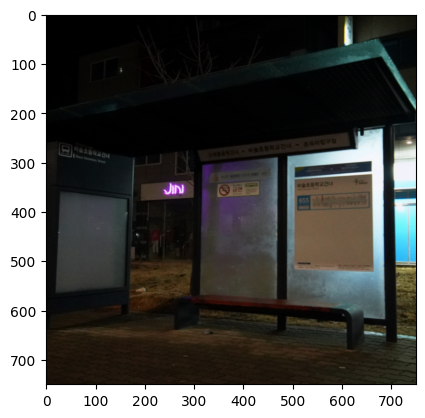

In [41]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, mask)
predict_single(*val_dataset[1497])

In [42]:
val_dataset.im_path(1497)

'../data/test/blur/clear_gt/real_blur/gt_489.png'

In [43]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

0
2
3
4
8
9
14
16
18
19
20
22
26
28
30
32
34
39
40
46
47
48
51
54
55
56
57
58
62
64
66
68
69
70
71
72
74
76
77
78
80
82
88
90
91
92
93
96
97
98
99
102
104
108
110
112
113
114
115
116
117
118
120
122
123
128
129
130
136
138
139
140
148
150
151
192
211
424
491
493
495
496
498
504
510
548
787
790
791
811
815
816
849
877
992
995
1004
1015
1017
1026
1034
1035
1037
1038
1046
1060
1063
1086
1238
1246
1342
1344
1345
1346
1347
1348
1350
1351
1353
1355
1356
1357
1358
1360
1361
1362
1363
1520
1523
1524
1525
1526
1527
1528
1529
1530
1531
1533
1534
1536
1537
1539
1632
1651
1663
1664
1687
1743
1754
1820
1978
1979
1981
1982
1984
1985
1986
1989
1990
1991
1992
1995
1996
1997
2044
2047
2054
2062
2073
2087
2089
2090
2093
2094
2106
2107
2108
2115
2126
2128
2133
2134
2136
2139
2144
2150
2152
2155
2167
2168
2172
2173
2174
2177
2181
2183
2189
2194
2198
2201
2209
2213
2216
2218
2224
2226
2230
2231
2234
2239
2240
2245
2247
2249
2250
2254
2260
2264
2268
2278
2281
2282
2288
2292
2294
2295
2296
2298
2302
2303
230

Label: clear
mask: blur

tensor([0.3652, 0.0099, 0.0007, 0.0010], device='cuda:0',
       grad_fn=<SelectBackward0>)


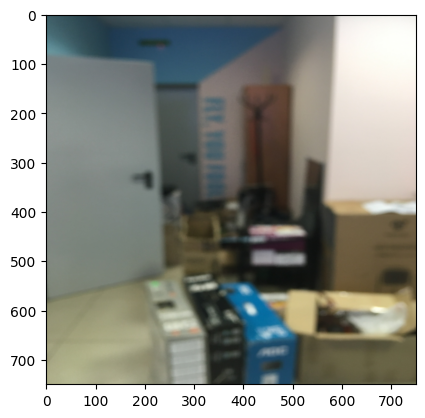

In [61]:
predict_single(*val_dataset[0])

In [62]:
val_dataset.im_path(0)

'../data/test/blur/0_IPHONE-SE_F.JPG'

Label: clear
mask: blur

tensor([0., 0., 0., 0.])


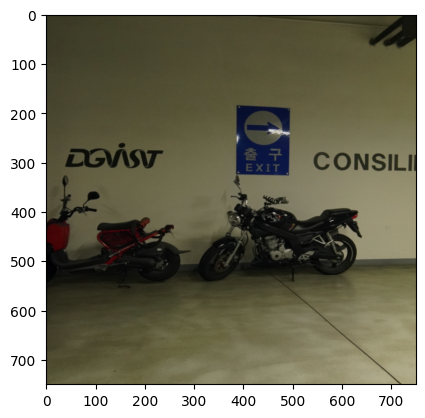

In [46]:
show_example(*val_dataset[1258])

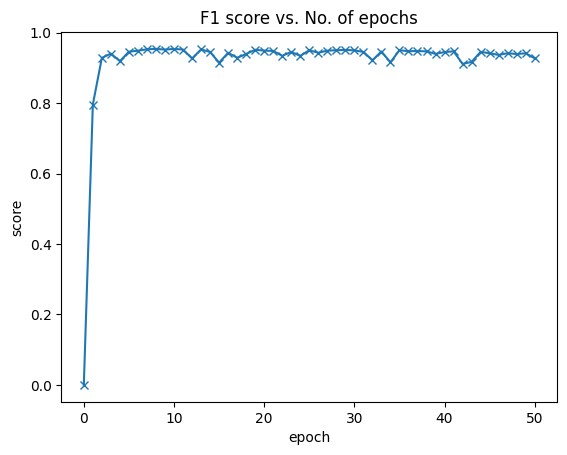

In [47]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

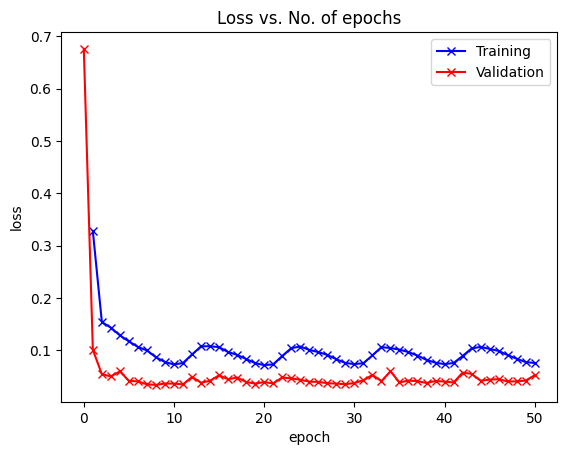

In [48]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

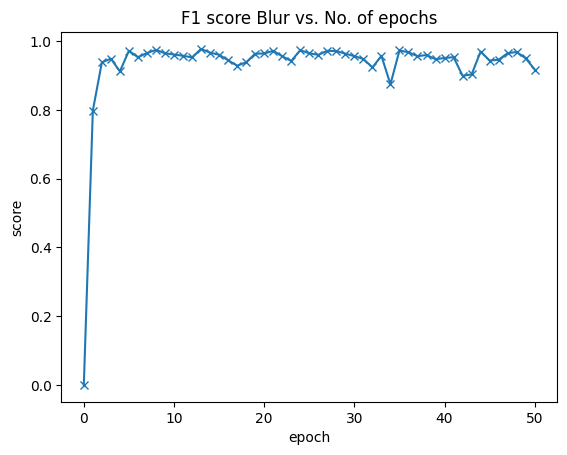

In [49]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

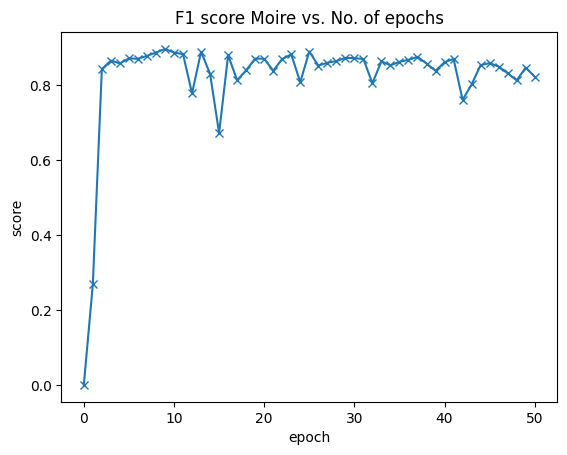

In [50]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

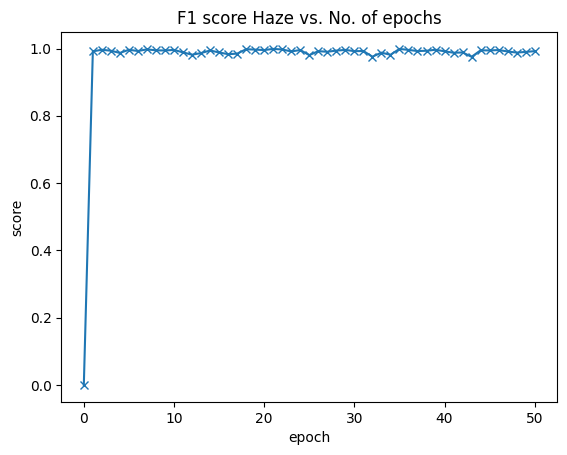

In [51]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

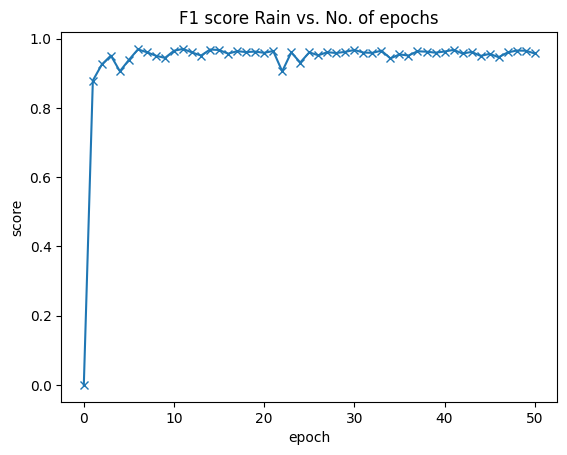

In [52]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

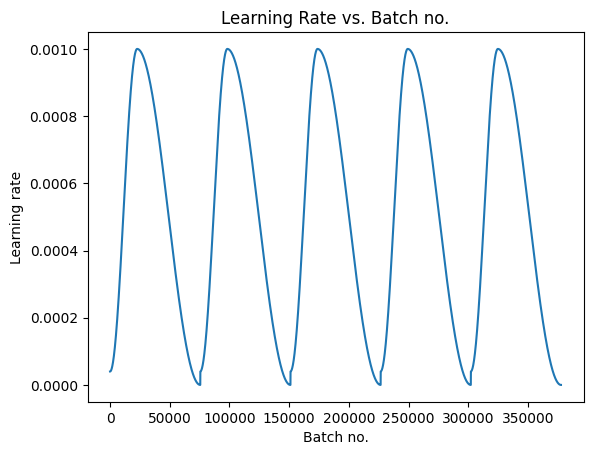

In [53]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [54]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([7.5740e-04, 4.1213e-04, 9.8139e-01, 8.7741e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


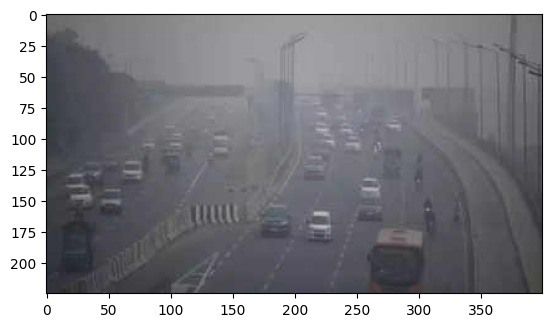

In [55]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([0.0042, 0.1165, 0.0012, 0.0039], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


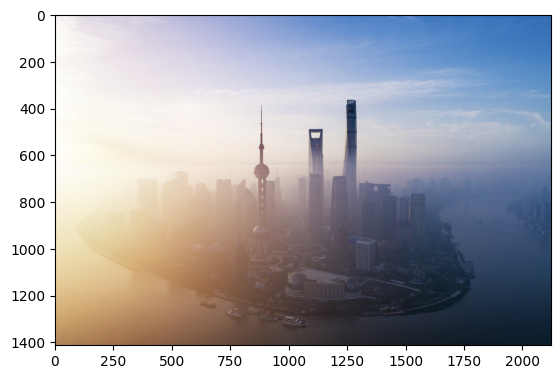

In [56]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.0011, 0.0560, 0.0003, 0.0050], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


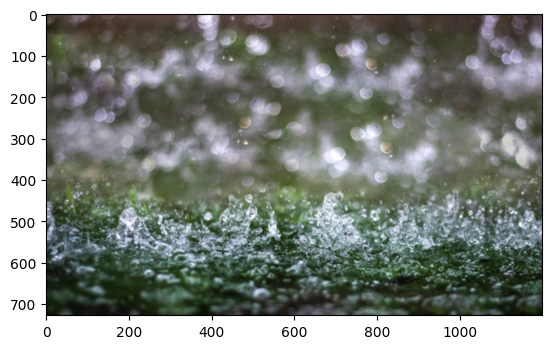

In [57]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Label: clear
mask: demoir

tensor([9.1673e-04, 2.6533e-02, 9.9076e-05, 9.5789e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


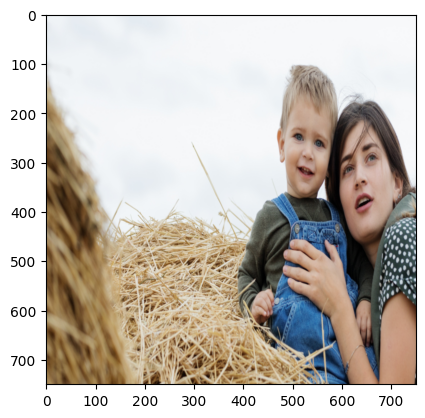

In [58]:
predict_single(*val_dataset[3282]) #checking out the predictions of some images from the validation dataset.

In [59]:
val_dataset.im_path(3282)

'../data/test/demoir/clear_gt/image_312.jpg'

In [60]:
PATH = os.path.join('../saved_models', datetime.now().strftime('shufflenet_750_custom_loss_frozen_full_data_16_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()